In [2]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any

import vis
import degcor
import overlapping
import sbm

In [3]:
DEV = 'cpu'


def make_utilities(population_size: int) -> torch.Tensor:
    """
    Make utility values to weight samples with.

    Args:
        population_size:

    Returns:
        utility_values: Shape (S,).
    """
    utility_values = np.log(population_size / 2. + 1) - \
                     np.log(np.arange(1, population_size + 1))
    utility_values[utility_values < 0] = 0.
    utility_values /= np.sum(utility_values)
    utility_values -= 1. / population_size
    utility_values = utility_values.astype(np.float32)
    return torch.tensor(utility_values)


def scale_noise(noise: torch.Tensor, fitness: torch.Tensor, log_probs: torch.Tensor) -> torch.Tensor:
    """
    Scale noise with the fitness values. Fitness values are assigned to noise
    vectors based on the `log_probs` vector. The better the `log_probs` vector,
    the higher the fitness and thus the more the gradient should point into
    that direction.

    Args:
        noise: Noise used to perturb the parameters (S, |V|, k).
        fitness: Vector of scalars, first element `fitness[0]` is the fitness corresponding
            to the best sample, the last element `fitness[-1] is the fitness
            for the worst sample. Has shape (S).
        log_probs: Log prob resulting from the sampled placements. Has shape (S,).

    Returns:
        scaled_noise: Noise scaled with fitness values. Has shape (S, |V|, d).
    """
    indices, sorted = torch.sort(-1. * log_probs)
    scaled_noise = fitness.unsqueeze(1).unsqueeze(2) * noise[sorted, :, :]
    return scaled_noise


def apply_gradient(params: torch.Tensor, grads: torch.Tensor, lr: float) -> torch.Tensor:
    """
    Apply the gradient to the parameters.

    Args:
        params: Tensor with parameters of shape (|V|, d).
        grads: Tensor with gradients of shape (|V|, d).

    Returns:
        params_prime: Tensor of shape (|V|, d).
    """
    params_prime = params + lr * grads
    return params_prime


def calculate_gradient(scaled_noise: torch.Tensor) -> torch.Tensor:
    """
    Calcualte the gradient from the scaled noise.

    Args:
        scaled_noise: Tensor of shape (S, |V|, d).

    Returns:
        grad: Tensor of shape (|V|, d).
    """
    grad = torch.sum(scaled_noise, 0)
    return grad


def estimate_eta(edges: torch.Tensor, assignments: torch.Tensor, k: int) -> torch.Tensor:
    """
    Maximum Likelihood estimate of block matrix from assignments. Returns one
    MLE estimate per sample.

    Args:
        edges: Shape (|V|, 2).
        assignments: Shape (S, |V|).

    Returns:
        eta: Shape (S, k, k)
    """
    z_tail = assignments[:, edges[:, 0]]  # Replace node id of tail with its group: (S, |E|)
    z_head = assignments[:, edges[:, 1]]  # Replace node id of head with its group: (S, |E|)

    # Shape (S, |E|, k)
    z_tail_one_hot = torch.unsqueeze(torch.nn.functional.one_hot(z_tail, k), -1)
    # Shape (S, |E|, k)
    z_head_one_hot = torch.unsqueeze(torch.nn.functional.one_hot(z_head, k), -2)

    # Count the number of edges that run between the different groups.
    # matmul has shape (S, |E|, k, k), reduce sum makes to (S, k, k).
    edges_btw_groups = torch.sum(torch.matmul(z_tail_one_hot, z_head_one_hot), dim=1).float()

    # One hot has shape (S, |V|, k), the sum then has shape (S, k), i.e., the
    # number of nodes in each group.
    num_members = torch.sum(torch.nn.functional.one_hot(assignments, k), 1)
    # Has shape (S, k, k), each entry in the matrix contains all possible edges
    # running in the group, including self-edges.
    all_edges_btw_groups = torch.matmul(
        torch.unsqueeze(num_members, -1),
        torch.unsqueeze(num_members, -2)
    )
    # Calculate the number of self-edges, returns a diagonal matrix of shape
    # (S, k, k), with the number of nodes in each group on the main diagonal.
    num_self_edges = torch.unsqueeze(torch.eye(k), 0) * torch.unsqueeze(num_members, 1)
    # Correct for self-edges.
    all_edges_btw_groups = all_edges_btw_groups - num_self_edges
    # Calculate MLE of eta.
    eta = edges_btw_groups / (torch.clip(all_edges_btw_groups.float(), 1e-9, 1e9))
    return eta


def bernoulli_logprob(edges: torch.Tensor, assignments: torch.Tensor,
                      eta: torch.Tensor, k: int) -> torch.Tensor:
    """
    Calculate the log prob for each assignment, given the MLE of eta.

    Args:
        edges: (|V|, 2)
        assignments (S, |V|)
        eta: (S, k, k)

    Returns:
        log_prob: Shape (S,)
    """
    z_tail = assignments[:, edges[:, 0]]  # Replace node id of tail with its group: (S, |E|)
    z_head = assignments[:, edges[:, 1]]  # Replace node id of head with its group: (S, |E|)

    # Shape (S, |E|, k)
    z_tail_one_hot = torch.unsqueeze(torch.nn.functional.one_hot(z_tail, k), -2).float()
    # Shape (S, |E|, k)
    z_head_one_hot = torch.unsqueeze(torch.nn.functional.one_hot(z_head, k), -1).float()

    ps = torch.matmul(torch.matmul(z_tail_one_hot, torch.unsqueeze(eta, -3)), z_head_one_hot)
    log_prob = torch.sum(torch.log(ps[:, :, 0, 0] + 1e-9), dim=-1)
    return log_prob


def sample_placements(mutated_params: torch.Tensor) -> torch.Tensor:
    """
    Sample indices from mutated paramters.

    Args:
        mutated_params: Shape (S, |V|, k)

    Returns:
        memberships: Shape (S, |V|).
    """
    cumsum = torch.cumsum(torch.softmax(mutated_params, dim=-1), dim=-1)
    noise = torch.rand(mutated_params.shape[0], mutated_params.shape[1], 1, requires_grad=False)
    indices = torch.argmin((cumsum < noise).int(), dim=-1)
    return indices


def mutate_params(params: torch.Tensor, num_samples: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Create `num_samples` mutation of parameters.

    Args:
        params: Shape (|V|, k)

    Returns:
        mutated_params: Shape (S, |V|, k)
    """
    noise = torch.randn([num_samples, params.shape[0], params.shape[1]], requires_grad=False)
    mutated_params = torch.unsqueeze(params, 0) + noise
    return noise, mutated_params


def learned_embeddings(edges: torch.Tensor, population_size: int, k: int,
                       num_nodes: int, lr: float, num_iter=10000,
                       params: torch.Tensor=None, patience: int=None) -> Dict[str, torch.Tensor]:
    if params is None:
        # Start from a uniform distribution over group memberships.
        params = torch.ones(num_nodes, k, requires_grad=False, device=DEV)
    fitness = make_utilities(population_size)

    all_losses = []
    best_loss = 1e9
    best_params = None
    best_eta = None
    best_assignment = None
    patience = int(num_iter * 0.1) if patience is None else patience
    iter = 0
    while iter < num_iter:
        iter += 1
        noise, mutations = mutate_params(params, population_size)
        assignments = sample_placements(mutations)
        etas = estimate_eta(edges, assignments, k)
        log_probs = bernoulli_logprob(edges, assignments, etas, k)
        log_probs[torch.isnan(log_probs)] = -1. * 1e9
        all_losses.append(log_probs.cpu().detach().numpy())

        bl = torch.min(-1. * log_probs)
        if bl <= best_loss:
            best_loss = bl.cpu().detach()
            idx = torch.argmax(log_probs)
            best_params = mutations[idx, :, :]
            best_eta = etas[idx]
            best_assignment = assignments[idx]
            if iter + patience > num_iter and bl < best_loss:
                num_iter = iter + patience
        if iter % 100 == 0:
            print(iter, best_loss, torch.mean(log_probs))

        scaled_noise = scale_noise(noise, fitness, log_probs)
        grads = calculate_gradient(scaled_noise)
        params = apply_gradient(params, grads, lr)

    return {
        "best_eta": best_eta.cpu(),
        "best_assignment": best_assignment.cpu(),
        "best_params": best_params.cpu(),
        "best_log_prob": -1. * bl,
        "params": params.cpu()
    }

100 tensor(252.1429) tensor(-297.1541)
200 tensor(235.2160) tensor(-274.3315)
300 tensor(229.9612) tensor(-257.2263)
400 tensor(229.9612) tensor(-247.9646)
500 tensor(229.9612) tensor(-243.5696)
600 tensor(229.9612) tensor(-239.0356)
700 tensor(229.9612) tensor(-235.6353)
800 tensor(229.9612) tensor(-234.2620)
900 tensor(229.9612) tensor(-233.3574)
1000 tensor(229.9612) tensor(-233.0531)
1100 tensor(229.9612) tensor(-232.9465)
1200 tensor(229.9612) tensor(-232.6299)
1300 tensor(229.9612) tensor(-232.5429)
1400 tensor(229.9612) tensor(-232.2313)
1500 tensor(229.9612) tensor(-231.8334)
1600 tensor(229.9612) tensor(-231.8814)
1700 tensor(229.9612) tensor(-231.6193)
1800 tensor(229.9612) tensor(-231.4757)
1900 tensor(229.9612) tensor(-231.3463)
2000 tensor(229.9612) tensor(-231.4390)
2100 tensor(229.9612) tensor(-231.2850)
2200 tensor(229.9612) tensor(-231.1541)
2300 tensor(229.9612) tensor(-230.8867)
2400 tensor(229.9612) tensor(-230.9974)
2500 tensor(229.9612) tensor(-231.0143)
2600 tens

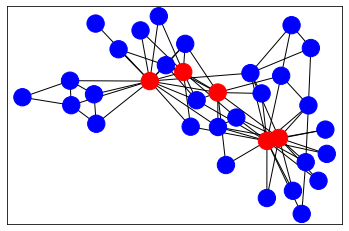

In [5]:
edges = []
for i in range(10):
    for j in range(10):
        if i == j:
            continue
        if i < 5 and j >= 5:
            continue
        if i >= 5 and j < 5:
            continue
        edges.append([i, j])
edges.append([5, 4])
edges.append([4, 5])
g = nx.karate_club_graph()
edges = list(g.to_directed().edges())
# print(edges)
edges = torch.tensor(edges, requires_grad=False)
# print(edges)

embeddings = learned_embeddings(edges, 1000, 2, g.number_of_nodes(), 0.1, 5000)
# print(embeddings)
print(torch.softmax(embeddings['best_params'], -1))
print(torch.softmax(embeddings['params'], -1))

members = embeddings['best_assignment']
colors = ['red' if members[i] == 1 else 'blue' for i in range(members.shape[0])]
pos = nx.spring_layout(g)
nx.draw_networkx_edges(g, pos=pos)
nx.draw_networkx_nodes(g, pos=pos, node_color=colors)
plt.savefig("000-graph-es.png")
plt.show()